In [8]:
import sys
sys.path.insert(0,'../')

from modERec import EnergyRec
import numpy as np

# Training stage

This block loops over a given set of simulations and writes the shower plane fluences and antenna positions to a file.

In [9]:
EnergyRec.bool_EarlyLate = True
EnergyRec.bool_plot = False
fluences_file = open("fluences_all.out",'w')
for i in range(100001,100008):
    simulation = "../files/sim" + str(i) + ".hdf5"
    rec = EnergyRec(simulation)
    for ant in rec.antenna:
        fluence = ant.fluence/(ant.wEarlyLate**2)
        if(fluence>rec.f_thres):
            x = (ant.r_proj[0] - rec.shower.r_Core_proj[0])*ant.wEarlyLate
            y = (ant.r_proj[1] - rec.shower.r_Core_proj[1])*ant.wEarlyLate
            sigma_f = ant.sigma_f/(ant.wEarlyLate**2)
            print(ant.ID, x, y, fluence, sigma_f, file=fluences_file)

fluences_file.close()

###  Determination of the $C$ parameters

The double gaussian parametrization has a set of parameters $C$ to be determined. In this block, these paramaters are fit to all the simulations at once.
This end the training stage.

In [10]:
rec = EnergyRec("fluences_all.out")
Cs =rec.bestfit[2:7]

* Model fit:
--> Done!




# $S_{radio}$ determination

With the $C$ parameters determined, a new fit is performed in order to determine $A$ and $\sigma$ for each simulation and obtain the $S_{radio}$ to be related with the cosmic ray energy.

In [11]:
import os
if os.path.exists("bestfit.out"):
    os.remove("bestfit.out")
for i in range(100001,100008):
    simulation = "../files/sim" + str(i) + ".hdf5"
    rec = EnergyRec(simulation)
    rec.model_fit("",Cs)

In [12]:
def model(x, A, B):
    return A*x**B

In [13]:
import scipy as sp
S_radio = np.loadtxt("bestfit.out")[:,-1]*1.e-9 # from eV to GeV
E_arr = np.loadtxt("bestfit.out")[:,-2]*1.e-9 # from GeV to EeV
AB_fit = sp.optimize.curve_fit(model,E_arr,S_radio,sigma=np.sqrt(S_radio))

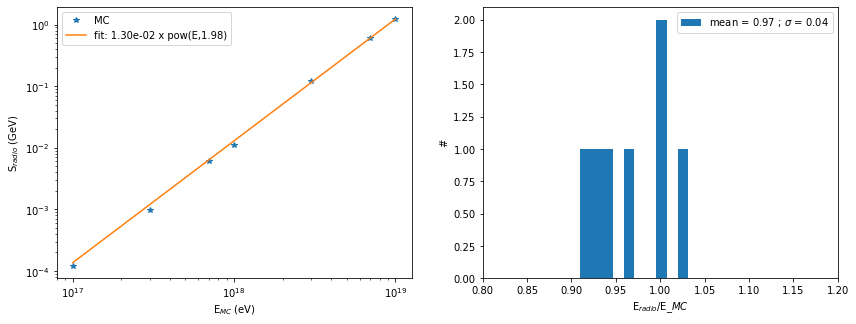

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.subplot(121)

plt.plot(E_arr*1.e+18,S_radio,"*",label="MC")
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.xlabel(r"E$_{MC}$ (eV)")
plt.ylabel(r"S$_{radio}$ (GeV)")

fit_x = np.linspace(np.min(E_arr),np.max(E_arr),100)
fit_y = model(fit_x,AB_fit[0][0],AB_fit[0][1])
fit_x = fit_x*1.e+18
fit_label = "fit: "+ "{:.2e}".format(AB_fit[0][0]) + " x pow(E,"+ "{:.2f}".format(AB_fit[0][1]) +")"

plt.plot(fit_x,fit_y,label=fit_label)
plt.legend()

plt.subplot(122)
relative = (S_radio - model(E_arr,AB_fit[0][0],AB_fit[0][1]))/model(E_arr,AB_fit[0][0],AB_fit[0][1])
re_label = r"(S$_{radio}$-fit)/fit"

erec = pow((S_radio/AB_fit[0][0]),1./AB_fit[0][1])/E_arr
stat = "mean = " +"{:.2f}".format(np.mean(erec)) + r" ; $\sigma$ = " + "{:.2f}".format(np.std(erec))
e_label = r"E$_{radio}$/E_${MC}$"
plt.hist(erec,label=stat)
plt.xlabel(e_label)
plt.xlim(0.8,1.2)
plt.ylabel("#")
plt.legend()